In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('data_prepared.csv')

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)
 
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)

y_train = np.log1p(df_train['salary_vnd'])
y_val = np.log1p(df_val['salary_vnd'])
y_test = np.log1p(df_test['salary_vnd'])
y_full_train = np.log1p(df_full_train['salary_vnd'])

del df_train['salary_vnd']
del df_val['salary_vnd']
del df_test['salary_vnd']
del df_full_train['salary_vnd']

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_percentage_error

In [3]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(train_dicts)
X_train = dv.transform(train_dicts)
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [4]:
# I try to train with basic model with no params tuning first
rf = RandomForestRegressor(n_estimators=10, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
round(root_mean_squared_error(y_val, y_pred),3)

0.321

In [10]:
# I got n_estimators = 45 from a previous tuning run, but I lost that result and couldn’t reproduce it because rerunning the search takes too much time.
scores_with_max_depth = []

for d in np.arange(5, 51, 5):
    rf = RandomForestRegressor(n_estimators=45, max_depth=d, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    score = round(root_mean_squared_error(y_val, y_pred),3)
    scores_with_max_depth.append((n, score))
    print(f'With max_depth: {d}, rmse: {score}')

With max_depth: 5, rmse: 0.306
With max_depth: 10, rmse: 0.286
With max_depth: 15, rmse: 0.286
With max_depth: 20, rmse: 0.286
With max_depth: 25, rmse: 0.286
With max_depth: 30, rmse: 0.286
With max_depth: 35, rmse: 0.287
With max_depth: 40, rmse: 0.287
With max_depth: 45, rmse: 0.287
With max_depth: 50, rmse: 0.288


In [5]:
# As shown in the results above, max_depth = 10 to 30 are the same. I will choose the smallest one for tuning with max_leaf_nodes
scores_with_mln = []

for mln in np.arange(5, 26, 5):
    rf = RandomForestRegressor(n_estimators=45, max_depth=10, max_leaf_nodes=mln, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    score = round(root_mean_squared_error(y_val, y_pred),3)
    scores_with_mln.append((mln, score))
    print(f'With max_leaf_nodes: {mln}, rmse: {score}')

With max_leaf_nodes: 5, rmse: 0.312
With max_leaf_nodes: 10, rmse: 0.289
With max_leaf_nodes: 15, rmse: 0.286
With max_leaf_nodes: 20, rmse: 0.286
With max_leaf_nodes: 25, rmse: 0.286


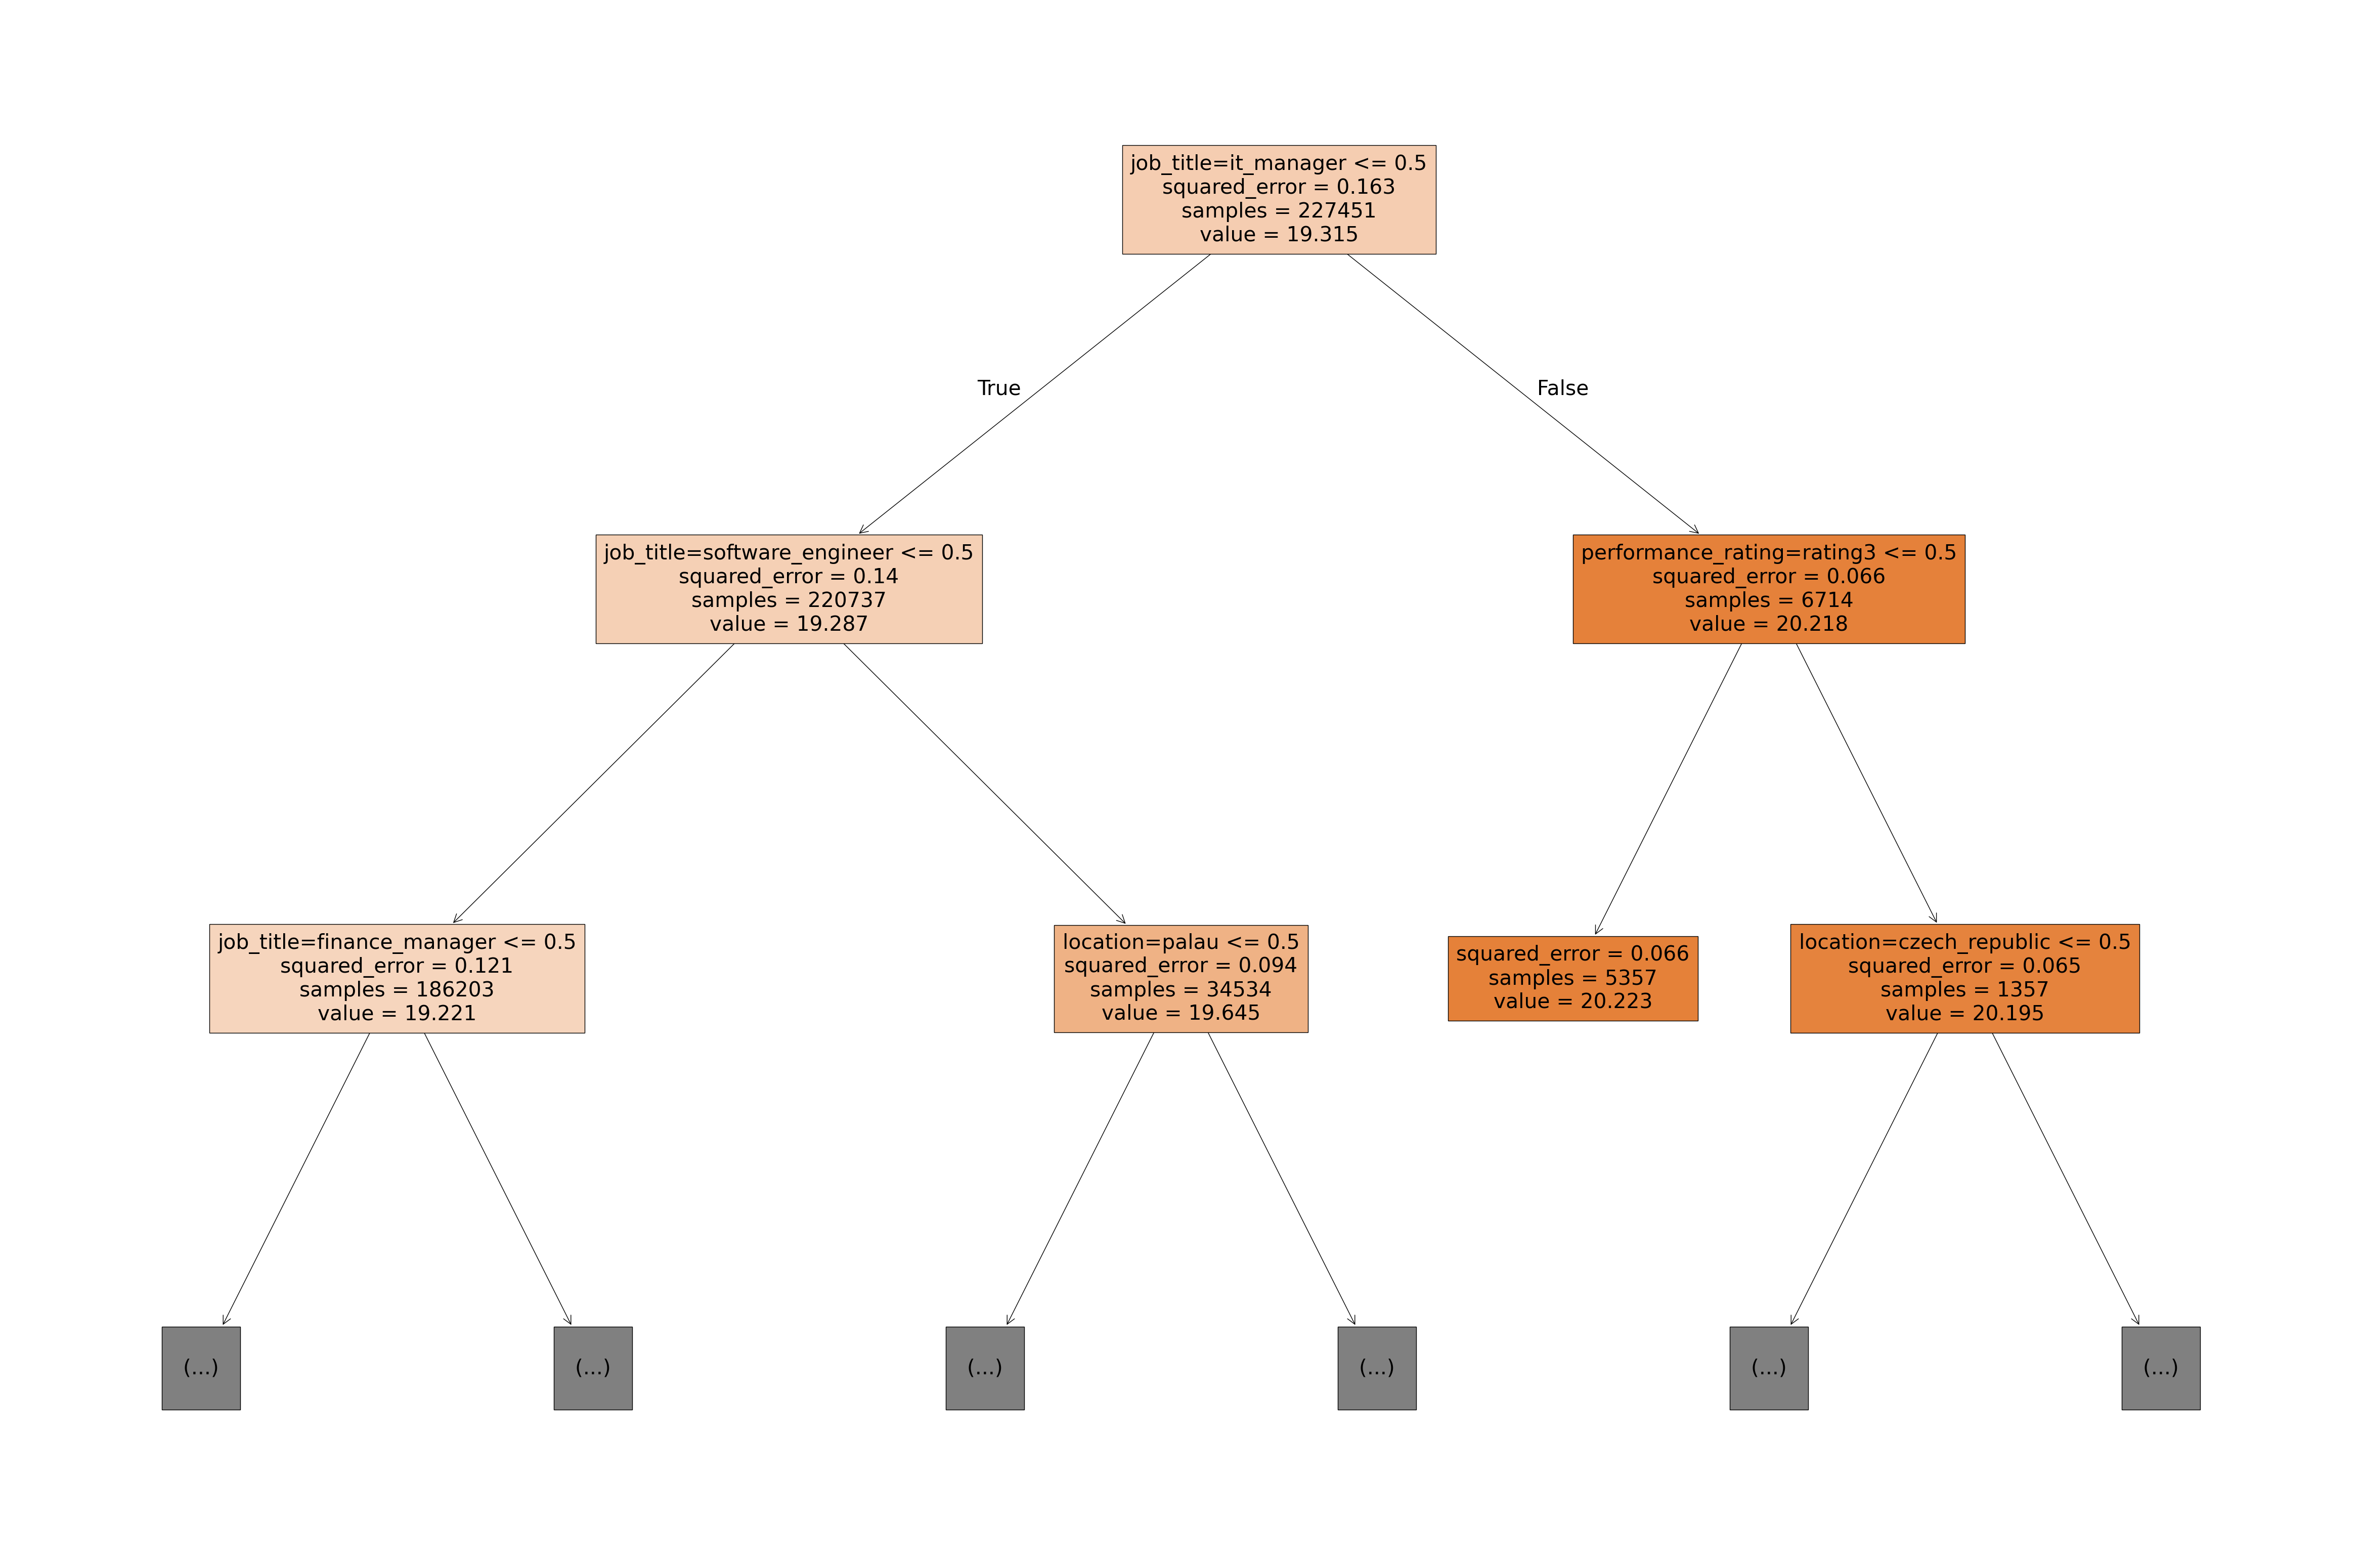

In [19]:
# Now let see how my tree look like
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

estimator = rf.estimators_[0]

plt.figure(figsize=(60,40))
plot_tree(estimator, filled=True, max_depth=2, feature_names=dv.get_feature_names_out().tolist(), class_names=True)
plt.show()

In [28]:
# I will choose max_leaf_nodes = 15 from now on.
# This time I try with max_feature
feature_names = dv.get_feature_names_out()

In [30]:
len(feature_names)

291

In [33]:
for mf in ['sqrt', 'log2']:
    rf = RandomForestRegressor(n_estimators=45, max_depth=10, max_leaf_nodes=15, max_features=mf, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    score = round(root_mean_squared_error(y_val, y_pred),3)
    print(f'With max_feature_mode: {mf}, rmse: {score}')

With max_feature_mode: sqrt, rmse: 0.321
With max_feature_mode: log2, rmse: 0.359


In [34]:
scores_with_mf = []

for mf in [50, 100, 150, 200, 250, 291]:
    rf = RandomForestRegressor(n_estimators=45, max_depth=10, max_leaf_nodes=15, max_features=mf, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    score = round(root_mean_squared_error(y_val, y_pred),3)
    scores_with_mf.append((mf, score))
    print(f'With max_feature: {mf}, rmse: {score}')

With max_feature: 50, rmse: 0.295
With max_feature: 100, rmse: 0.287
With max_feature: 150, rmse: 0.286
With max_feature: 200, rmse: 0.286
With max_feature: 250, rmse: 0.286
With max_feature: 291, rmse: 0.286


In [37]:
# Find importances features
importances = rf.feature_importances_

df_feature_importance = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(df_feature_importance)

                                    feature  importance
23                     job_title=it_manager    0.309277
34              job_title=software_engineer    0.283834
17                job_title=finance_manager    0.123565
11   job_title=business_development_manager    0.095299
20                   job_title=hr_executive    0.050386
..                                      ...         ...
284              performance_rating=rating5    0.000000
283              performance_rating=rating4    0.000000
5                            department=r&d    0.000000
4                     department=operations    0.000000
3                      department=marketing    0.000000

[291 rows x 2 columns]


In [38]:
# After trying the two parameters min_samples_split and min_samples_leaf with DecisionTreeRegressor and not observing any significant improvement, I will not pursue tuning these two parameters further.
# Train final model with full_train dataset
full_train_dicts = df_full_train.to_dict(orient='records')
X_full_train = dv.transform(full_train_dicts)
test_dicts = df_test.to_dict(orient='records')
X_test = dv.transform(test_dicts)

In [40]:
rf = RandomForestRegressor(n_estimators=45, max_depth=10, max_leaf_nodes=15, max_features=150, random_state=42, n_jobs=-1)
rf.fit(X_full_train, y_full_train)
y_pred = rf.predict(X_test)
rmse = round(root_mean_squared_error(y_test, y_pred),3)
r2 = round(r2_score(y_test, y_pred),3)
mape = round(mean_absolute_percentage_error(y_test, y_pred),3) * 100

In [41]:
print(f'rmse: {rmse}')
print(f'r2: {r2}')
print(f'mape: {mape}%')

rmse: 0.288
r2: 0.495
mape: 1.3%
